
<H1 style=text-align:center;>Projet de Licence en Informatique parcours Math-INFO</H1>
<h1 style=text-align:center;>Enseignante : Raquel URENA</h3>

<h2 style=text-align:center;>Sujet choisi: </h3>
<h2 style=text-align:center;>Réseaux Bayésiens pour la Décision Clinique Interprétable</h3>

<h2 style=text-align:center;>Membres du groupe par ordre alphabétique:</h3>
<h2 style=text-align:center;>Joséphine HERMANS, Hiromi SUIDO, Michael TEIXEIRA </h3>

# Plan de développement

# Gestion de configuration
L'équipe utilise github pour gérer la configuration du projet. Le repository github possède une branch nommée 'main'. 
- Lorsqu'un membre de l'équipe developpe une nouvelle fonctionalité, celle-ci doit être developpée dans une branche.
- lorsque le développement de la fonctionnalité est terminée, le membre d'équipe crée une merge request dans github
- la merge request est revue par un membre de l'équipe.
- si la fonctionnalité est bonne, la branche peut être mergée avec la branche 'main'.

## Libarie python utilisée

Packages python nécessaires:
- kagglehub: pour le téléchargement du dataset
- numpy, pandas: pour la manipulation de donnée
- matplotlib, seaborn: pour la visualisation de donnée
- graphviz: pour la visualisation du réseau bayesien

In [1]:

%pip install -q \
    kagglehub \
    numpy \
    pandas \
    matplotlib \
    seaborn \
    graphviz \
    IPython

from IPython.display import Image
import pandas as pd
import numpy as np
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz


Note: you may need to restart the kernel to use updated packages.


## Outils utilisés

- Notebook jupyter: pour le rapport et le code
- Python 3: language utilisé pour développer le programme et le notebook
- Drawio: Pour créer les schémas
- projetlibre pour les diagrammes de Gantt

# Vérification du code
La vérification du code est faite par une vérication du guide PEP8. Le code est aussi vérifié par revue du code par un membre de l'équipe avant merge dans la branche master du code sur github

In [2]:
%pip install pycodestyle pycodestyle_magic
%load_ext pycodestyle_magic

Note: you may need to restart the kernel to use updated packages.


# Validation
- La validation du code doit passer par des tests unitaires dont le nom de fonction commence par "test_".
- Un membre du projet doit valider le code

## Planning
Voici le planning suivi par notre projet:

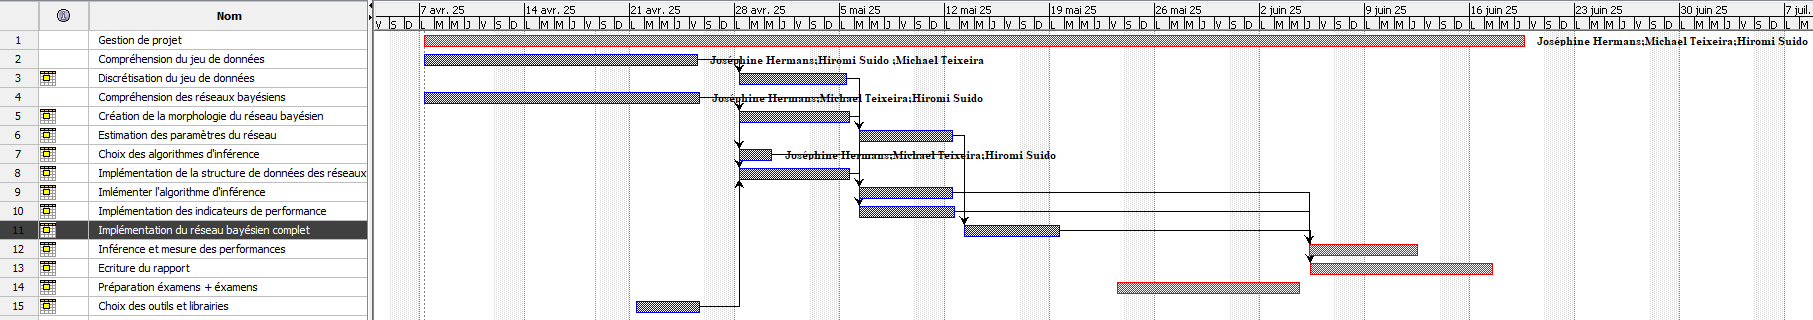

In [3]:
Image("gestion_de_projet/planning_gantt_20250418.png")

Le développement suit un modèle V tel que vu ci-dessous

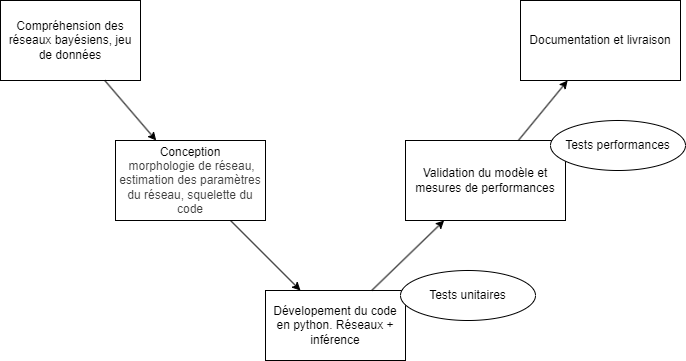

In [4]:
Image("gestion_de_projet/dev_plan.png")

# Préparation des données

### Téléchargement du dataset

In [5]:
path = kagglehub.dataset_download("uciml/pima-indians-diabetes-database")
print(f"Path to dataset files: {path}\n")
raw_dataset = pd.read_csv(path + "/diabetes.csv")

Path to dataset files: /Users/hiromi/.cache/kagglehub/datasets/uciml/pima-indians-diabetes-database/versions/1



## Signification des paramètres du jeu de donnée

le jeu de données donne les résultats de tests fait sur des patient non atteint de diabète pour les premiers paramtres. Le dernier paramètre "Outcome" nous donne si 5 ans aprés les tests, la personne est maintenant atteinte de diabète. Il s'agit donc de créer un outil de machine learning permettant de prévoir si une personne va être diabétique ou non dans un avenir proche. 

- Pregnancies: Nombre de grossesse du sujet
- Glucose: concentration de glucose après un test de glycémie orale
  - Tolérance normale : < 140 mg/dL
  - Intolérance : 140-199 mg/dL
  - Diabète >= 200 mg/dL. 
  - Aucun sujet n'a cette valeure au dessus de 200 mg/dL car c'est la confirmation du diabète, hors on veut prévoir la probabilité de contracté le diabète sur des sujet sains.
- BloodPressure: Diastolic Blood Pressure (mm Hg). C'est la pression artérielle diastolique 
  - Normale : entre 60 et 79 mm Hg
  - Élevée (pré-hypertension) : 80 à 89 mm Hg
  - Hypertension de stade 1 : ≥ 90 mm Hg
- SkinThickness: épaisseur de la peau au niveau du pli cutané
  - Normal: 20–35
  - Faible < 15
  - Elevé > 40
- Insulin: Concentration d’insuline sérique 2h après le test de glycémie orale
  - Normal: 16–166
  - hypoinsuline: < 16
  - Hyperinsulinémie: > 166
- BMI: Indice de masse corporelle
  - Normal: 18.5 - 25
  - Maigre: < 18.5
  - Surpoids 25 - 30
  - obésité > 30
- DiabetesPedigreeFunction: Indicateur du risque héréditaire de diabète
  - normal: 0 - 0.5
  - à risque: > 0.5
- Age: Âge de la personne
- Outcome: Le sujet a le diabète 5 ans après les tests: 1, sinon 0 


### Affichage de satistiques de base du set de donnée

In [6]:
raw_dataset.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Analyse du set de donnée

Plusieurs entrées ont des valeurs égales à 0, ce qui n'a aucun sens car médicalement impossible (en tout cas sans décès):
- Glucose
- BloodPressure
- SkinThickness
- Insulin
- BMI

On transformer ces valeurs en `np.nan` pour qu'il n'entre pas en compte dans l'analyse.

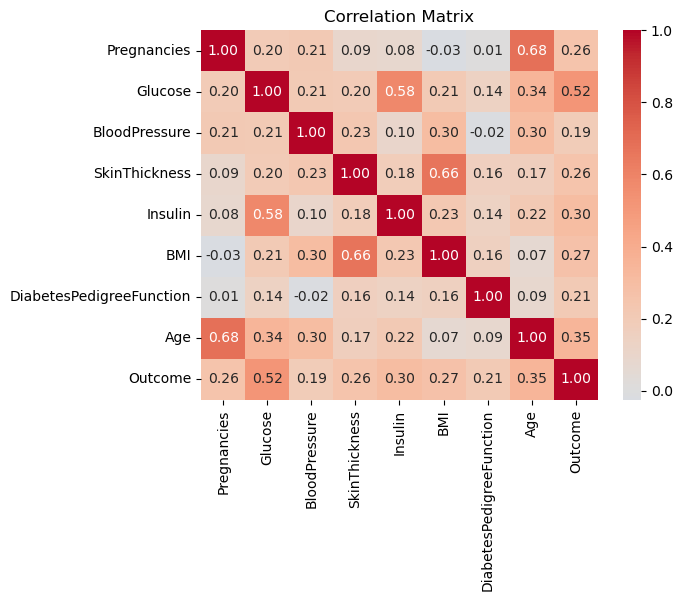

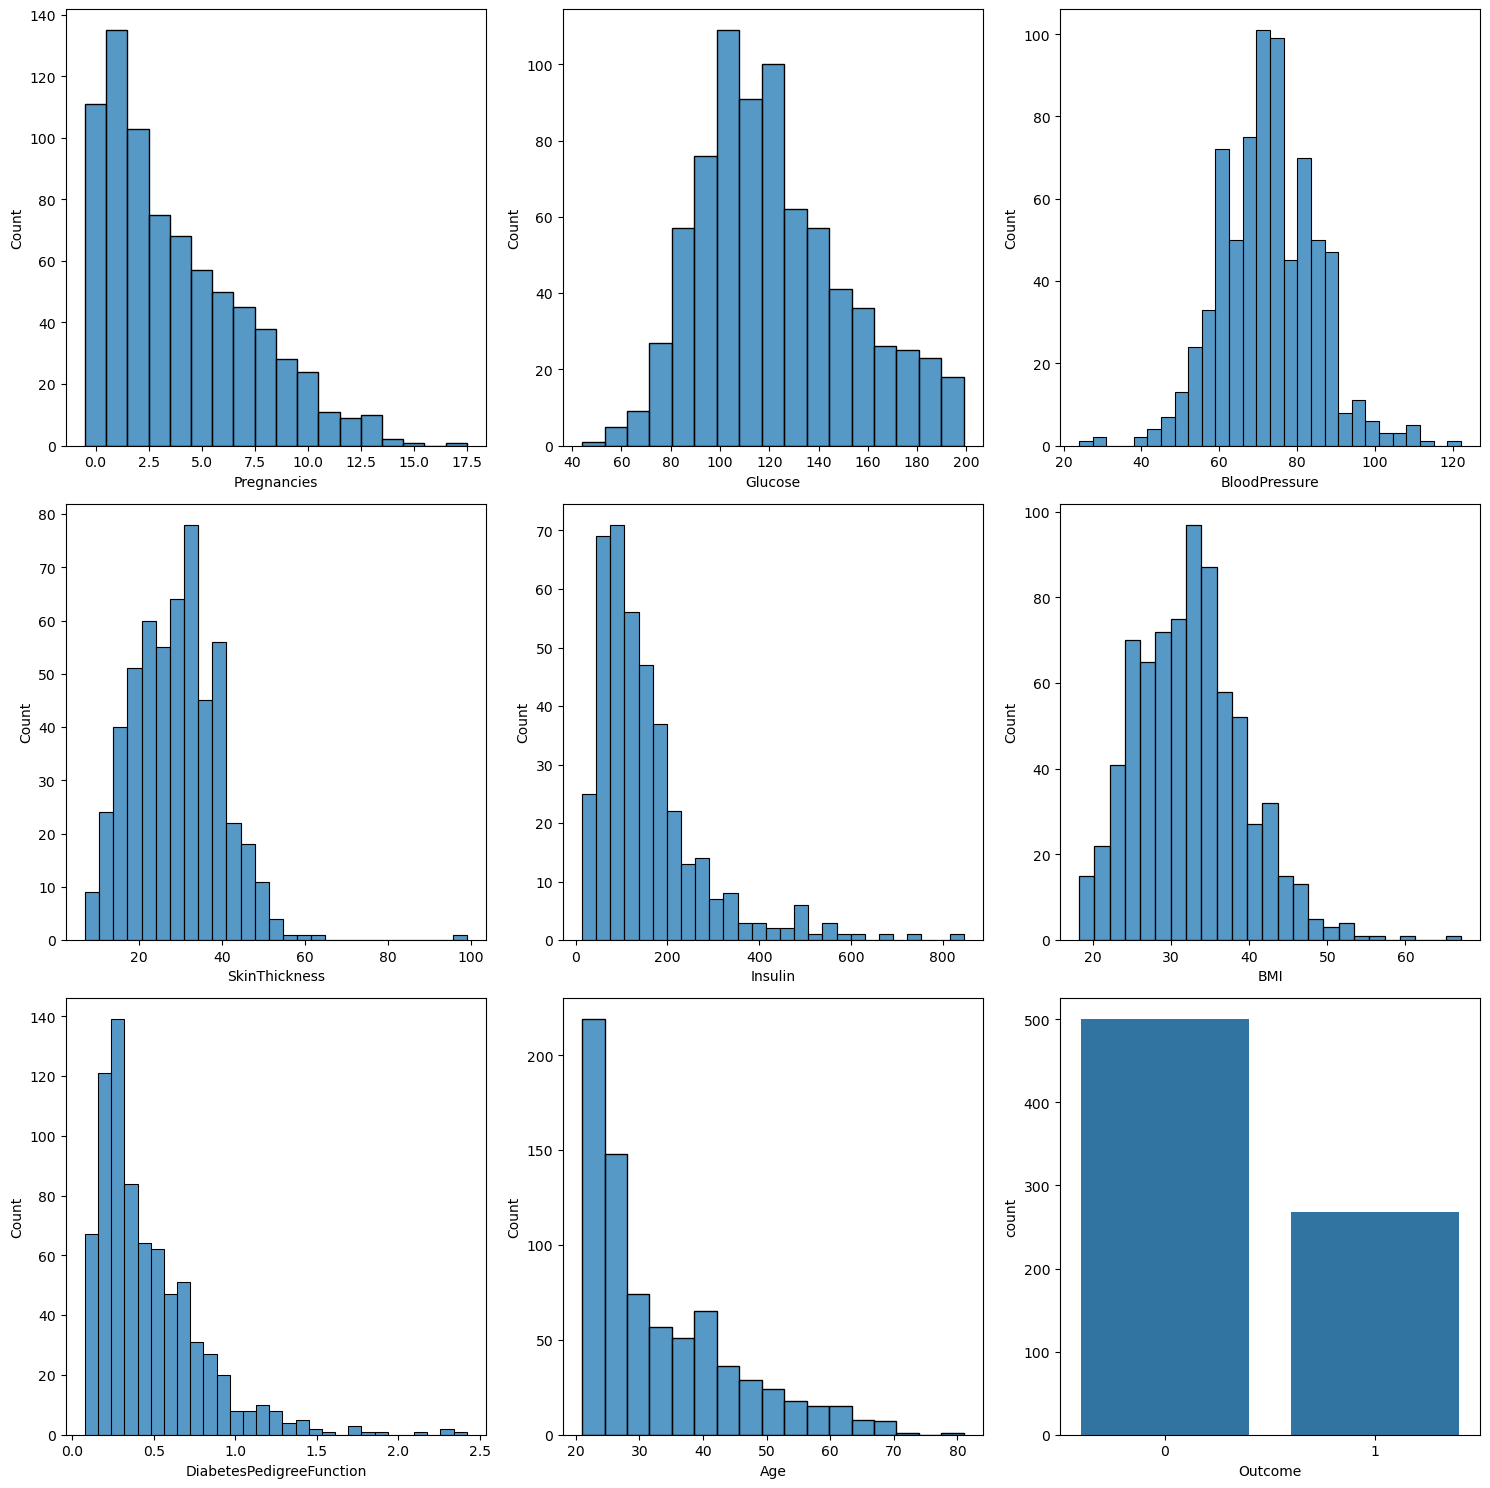

In [7]:
full_dataset = raw_dataset.copy()

non_null_columns = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
full_dataset[non_null_columns] = full_dataset[non_null_columns].replace(0, np.nan)

correlation_matrix = full_dataset.dropna().corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", center=0, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
sns.histplot(full_dataset["Pregnancies"].dropna(), ax=axes[0, 0], discrete=True)
sns.histplot(full_dataset["Glucose"].dropna(), ax=axes[0, 1])
sns.histplot(full_dataset["BloodPressure"].dropna(), ax=axes[0, 2])
sns.histplot(full_dataset["SkinThickness"].dropna(), ax=axes[1, 0])
sns.histplot(full_dataset["Insulin"].dropna(), ax=axes[1, 1])
sns.histplot(full_dataset["BMI"].dropna(), ax=axes[1, 2])
sns.histplot(full_dataset["DiabetesPedigreeFunction"].dropna(), ax=axes[2, 0])
sns.histplot(full_dataset["Age"].dropna(), ax=axes[2, 1])
sns.countplot(data=full_dataset, x="Outcome", ax=axes[2, 2])
plt.tight_layout()
plt.show()

On peut identifier certaines variables fortement corrélées:
- Age - Pregnencies
- BMI - SkinThickness
- Insulin - Glucose
- Glucose - Outcome

### Discrétisation des données

In [8]:
def bin_column(data, column_name, num_bins):
    _, generated_bins = pd.qcut(data[column_name], num_bins, retbins=True)
    generated_bins = np.unique(generated_bins)
    generated_bins[0], generated_bins[-1] = -np.inf, np.inf
    data[column_name] = pd.cut(data[column_name], bins=generated_bins)

binned_dataset = full_dataset.copy()
bin_column(binned_dataset, "Glucose", 5)
bin_column(binned_dataset, "BloodPressure", 2)
bin_column(binned_dataset, "SkinThickness", 3)
bin_column(binned_dataset, "Insulin", 4)
bin_column(binned_dataset, "BMI", 3)
bin_column(binned_dataset, "DiabetesPedigreeFunction", 2)
bin_column(binned_dataset, "Age", 4)
bin_column(binned_dataset, "Pregnancies", 3)

# Création du réseau Bayesien

### Implementation du réseau

In [9]:
"""Class to manage a Bayesian Network
This class allows to create a Bayesian Network, add nodes and edges,
and estimate the conditional probabilities of each node based on the data.
"""
class BayesianNetwork:
    class _BayesianNode:
        
        """Constructor for the BayesianNode class
        """
        def __init__(self, name):
            self.name = name
            self.parents = []
            self.children = []
            self.probabilities = None

        """Function to add a child to a node
            This function checks if the child node is not already a parent or child of the current node
        """
        def add_child(self, child_node):
            if child_node == self:
                raise ValueError(f"Node {self.name} cannot be its own child")
            if child_node in self.parents:
                raise ValueError(f"Node {child_node.name} is already a parent of {self.name}")
            if child_node in self.children:
                raise ValueError(f"Node {child_node.name} is already a child of {self.name}")
            self.children.append(child_node)
            child_node.parents.append(self)

        """Simple frequencialistic estimation of the conditional probabilities
            Alpha is the smoothing parameter
            (Laplace smoothing which is a special case of Dirichlet prior)
        """
        def estimate_probabilities(self, data, alpha=1):
            if not self.parents:
                data_series = data[self.name].dropna()
                self.probabilities = data_series.value_counts(normalize=True)
            else:
                parent_columns = [parent.name for parent in self.parents]
                data_subset = data[parent_columns + [self.name]].dropna()

                grouped = data_subset.groupby(parent_columns + [self.name], observed=False).size()
                if alpha != 0:
                    grouped += alpha
                else:
                    # if alpha == 0, we add 1 to every 0 entries to avoid division by zero
                    grouped[grouped == 0] += 1
                unstacked = grouped.unstack(fill_value=0)
                self.probabilities = unstacked.div(unstacked.sum(axis=1), axis=0).stack()

    """Constructor for the BayesianNetwork class
        This class allows to create a Bayesian Network, add nodes and edges,
        and estimate the conditional probabilities of each node based on the data.
    """
    def __init__(self):
        self.nodes = []
        self.root_nodes = []

    def getNode(self, name):
        """Function to get a node by its name
        """
        node = next((node for node in self.nodes if node.name == name), None)
        if node is None:
            raise ValueError(f"Node '{name}' not found in the network")
        return node

    """Function to add a node to the network
    """
    def add_node(self, name, **kargs):
        new_node = BayesianNetwork._BayesianNode(name, **kargs)
        self.nodes.append(new_node)
        self.root_nodes.append(new_node)

    """Function to add an edge between two nodes
    """
    def add_edge(self, parent_node_name, child_node_name):
        parent_node = next((node for node in self.nodes if node.name == parent_node_name), None)
        if parent_node is None:
            raise ValueError(f"Parent node '{parent_node_name}' not found in the network")
        child_node = next((node for node in self.nodes if node.name == child_node_name), None)
        if child_node is None:
            raise ValueError(f"Child node '{child_node_name}' not found in the network")
        if child_node in self.root_nodes:
            self.root_nodes.remove(child_node)
        parent_node.add_child(child_node)

    """Function to estimate the conditional probabilities of each node
    """
    def estimate_probabilities(self, data, alpha=1):
        if alpha < 0:
            raise ValueError("Alpha must be non-negative")
        if data is None:
            raise ValueError("Data cannot be None")
        
        for node in self.nodes:
            node.estimate_probabilities(data, alpha)

In [10]:
# Testing the BayesianNetwork with three nodes and two arrows, then assert the result
def test_bayesian_network():
    # Create a simple Bayesian Network
    test_bn = BayesianNetwork()
    test_bn.add_node("A")
    test_bn.add_node("B")
    test_bn.add_node("C")

    # Add edges
    test_bn.add_edge("A", "B")
    test_bn.add_edge("B", "C")

    # Create a small test dataset
    test_data = pd.DataFrame({
        "A": [0, 0, 0, 0],
        "B": [1, 1, 1, 1],
        "C": [0, 1, 0, 1]
    })

    # Estimate probabilities
    test_bn.estimate_probabilities(test_data, alpha=1)
    
    # Check the probalities for each node     
    target_node = test_bn.getNode("A")
    assert target_node.probabilities[0] == 1.0, "Node A probabilities are incorrect"
    target_node = test_bn.getNode("B")
    assert target_node.probabilities.values[0]== 1.0, "Node A probabilities are incorrect"
    target_node = test_bn.getNode("C")
    assert target_node.probabilities.values[0]== 0.5, "Node A probabilities are incorrect"

    print("Simple Bayesian Network test passed.")

test_bayesian_network()

Simple Bayesian Network test passed.


### Définition de la structure du réseau

On choisit dans un premier temps pour expérimenter un "Tree-Augmented Bayesian Network" avec une structure intuitivement cohérente.

In [11]:
### Creating a bayesian network based on the dataset parameters
network = BayesianNetwork()

# Creating the nodes
network.add_node("Age")
network.add_node("DiabetesPedigreeFunction")
network.add_node("Pregnancies")
network.add_node("BMI")
network.add_node("BloodPressure")
network.add_node("SkinThickness")
network.add_node("Glucose")
network.add_node("Insulin")
network.add_node("Outcome")

# creating the edges between the nodes
network.add_edge("Outcome", "Age")
network.add_edge("Outcome", "DiabetesPedigreeFunction")
network.add_edge("Outcome", "Pregnancies")
network.add_edge("Outcome", "BMI")
network.add_edge("Outcome", "BloodPressure")
network.add_edge("Outcome", "SkinThickness")
network.add_edge("Outcome", "Glucose")
network.add_edge("Outcome", "Insulin")

network.add_edge("Age", "Pregnancies")
network.add_edge("Pregnancies", "Insulin")
network.add_edge("Insulin", "Glucose")
network.add_edge("Insulin", "BMI")
network.add_edge("BMI", "BloodPressure")
network.add_edge("BMI", "SkinThickness")

# Esimating the conditionnal probabilities for each node
network.estimate_probabilities(binned_dataset, alpha=0)

### Visualisation du réseau

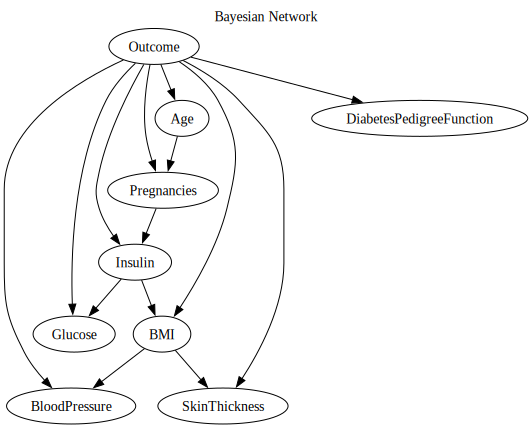

In [12]:
"""Function to draw the Bayesian Network
    This function uses the graphviz library to create a visual representation of the Bayesian Network.
    It recursively draws each node and its children, creating edges between them.
"""
def draw_bayesian_network(dot, bn):
    drawn = set()
    def draw_node(dot, node):
        if node.name in drawn:
            return
        drawn.add(node.name)
        dot.node(node.name, label=node.name)
        for child in node.children:
            draw_node(dot, child)
            dot.edge(node.name, child.name)

    drawn.clear()
    for node in bn.root_nodes:
        draw_node(dot, node)

# Creating a directed graph using graphviz to represent the Bayesian Network
dot = graphviz.Digraph()
dot.attr(label="Bayesian Network")
dot.attr(labelloc="t")
draw_bayesian_network(dot, network)
dot

# Inférence

La première méthode est une méthode stochastique appelée "Likelihood Weighting"

In [13]:
"""This function performs inference using likelihood weighting.
   It takes a Bayesian network, a target node name, and evidence as input.
   It returns the estimated probabilities of the target node given the evidence.
   evidence is a list of the node names that we want to use the values of.
   taget_node is the name of the node we want to estimate the probabilities for.
"""
def inference_likelihood_weighting(network, target_node_name, evidence):
    target_node = next((node for node in network.nodes if node.name == target_node_name), None)
    if target_node is None:
        raise ValueError(f"Target node '{target_node_name}' not found in the network")

    counts = {}
    for value in target_node.probabilities.index.levels[-1]:
        counts[value] = 0
    
    total_counts = 0
    for _ in range(10000):
        likelihood = 1
        values = {}
        for node in network.nodes:
            if not node.parents:
                probabilities = node.probabilities
            else:
                parent_values = tuple(values[parent.name] for parent in node.parents)
                probabilities = node.probabilities.xs(parent_values, level=list(range(len(parent_values))))
            if node.name in evidence:
                values[node.name] = evidence[node.name]
                likelihood *= probabilities[evidence[node.name]]
            else:
                values[node.name] = np.random.choice(probabilities.index, p=probabilities.values)

        total_counts += likelihood
        counts[values[target_node.name]] += likelihood
    
    # Normalize the counts
    for key in counts:
        counts[key] = float(counts[key] / total_counts) if total_counts > 0 else 0
    return counts

La seconde méthode est une méthode de Monté Carlo par chaine de Markov appelée "Gibbs Sampling"

In [14]:
"""This function performs inference using Gibbs sampling.
    It takes a Bayesian network, a target node name, and evidence as input.
    evidence shall a list of the node names that we want to use the values of.
    taget_node is the name of the node we want to estimate the probabilities for.
"""
def inference_gibbs_sampling(network, target_node, evidence):
    burn_in = 1000
    sample_size = 5000

    # Initialize counts and total counts for target node
    target_node = next(node for node in network.nodes if node.name == target_node)
    
    values = {}
    for node in network.nodes:
        if node.name in evidence:
            values[node.name] = evidence[node.name]
        else:
            if not node.parents:
                probabilities = node.probabilities
            else:
                parent_values = tuple(values[parent.name] for parent in node.parents)
                probabilities = node.probabilities.xs(parent_values, level=list(range(len(parent_values))))
            values[node.name] = np.random.choice(probabilities.index, p=probabilities.values)

    target_node_values = {}
    for value in target_node.probabilities.index.levels[-1]:
        target_node_values[value] = 0
    for i in range(sample_size):
        for node in network.nodes:
            if node.name in evidence:
                continue

            if not node.parents:
                probabilities = node.probabilities
            else:
                parent_values = tuple(values[parent.name] for parent in node.parents)
                probabilities = node.probabilities.xs(parent_values, level=list(range(len(parent_values))))
            
            for child in node.children:
                if len(child.parents) > 1:
                    child_parent_values = tuple((i, values[parent.name]) for i, parent in enumerate(child.parents) if parent != node)
                    levels, child_parent_values = zip(*child_parent_values)
                    child_probabilities = child.probabilities.xs(child_parent_values, level=levels)
                else:
                    child_probabilities = child.probabilities
                idx = pd.IndexSlice
                probabilities *= child_probabilities[idx[:, values[child.name]]]

            probabilities /= probabilities.sum()
            values[node.name] = np.random.choice(probabilities.index, p=probabilities.values)
        
        if i >= burn_in:
            target_node_values[values[target_node.name]] += 1

    effective_sample_size = sample_size - burn_in
    for key in target_node_values:
        target_node_values[key] /= effective_sample_size
    return target_node_values

La troisième méthode est une méthode d'inférence exacte appelée "Variable Elimination".

In [15]:
"""This function performs inference using Gibbs sampling.
    It takes a Bayesian network, a target node name, and evidence as input.
    It returns the estimated probabilities of the target node given the evidence.
    evidences is a list of the node names that we want to use the values of.
    taget_node is the name of the node we want to estimate the probabilities for.
"""
def inference_variable_elimination(network, target_node, evidences):
    nodes = network.nodes

    # Step one: create the factors
    factors = [node.probabilities for node in nodes]

    # Step two: restrict the evidence variables
    for evidence_node, e in evidences.items():
        for i in range(len(factors)):
            f = factors[i]
            if evidence_node in f.index.names:
                if isinstance(f.index, pd.MultiIndex):
                    factors[i] = f.xs((e,), level=(evidence_node,))
                else:
                    factors[i] = pd.Series(f[e])

    # Step three: multiply factors and sum out the hidden variables
    hidden_variables = [node.name for node in nodes if node.name not in evidences and node.name != target_node]
    for v in hidden_variables:
        # Multiply all factors that contain the variable
        to_multiply = [(i, f) for i, f in enumerate(factors) if v in f.index.names]
        new_factor = None
        for _, f in to_multiply:
            if new_factor is None:
                new_factor = f
            else:
                new_factor = new_factor * f

        # Remove the factors that were multiplied
        # (reverese the order to avoid index issues)
        for i, _ in reversed(to_multiply):
            factors.pop(i)

        # Sum out the variable
        if (isinstance(new_factor.index, pd.MultiIndex)):
            group = [name for name in new_factor.index.names if name != v]
            new_factor = new_factor.groupby(level=group, observed=False).sum()
            factors.append(new_factor)

    # Step four: multiply the remaining factors
    final_factor = None
    for f in factors:
        if f.size == 1:
            continue
        if final_factor is None:
            final_factor = f
        else:
            final_factor = final_factor * f
    
    # Step five: normalize the final factor
    final_factor = final_factor / final_factor.sum()

    return final_factor

In [16]:
# Test for inference_variable_elimination
def test_inference_variable_elimination():
    # Create a simple Bayesian Network
    bn = BayesianNetwork()
    bn.add_node("A")
    bn.add_node("B")
    bn.add_node("C")
    bn.add_edge("A", "C")
    bn.add_edge("B", "C")

    # Create a small test dataset
    test_data = pd.DataFrame({
        "A": [0, 0, 1, 1],
        "B": [0, 1, 0, 1],
        "C": [1, 0, 1, 0]
    })

    # Estimate probabilities
    bn.estimate_probabilities(test_data, alpha=1)

    # Test inference: P(C | A=1)
    result = inference_variable_elimination(bn, "C", {"A": 1})
    assert result[0] == 0.5, "Inference result is incorrect"

    # Test inference: P(C | B=1)
    result = inference_variable_elimination(bn, "C", {"B": 1})
    assert result[0] == 1, "Inference result is incorrect"

    result = inference_variable_elimination(bn, "C", {"B": 1, "A":0})
    assert result[0] == 1, "Inference result is incorrect"

    print("Inference Variable Elimination test passed.")

test_inference_variable_elimination()

Inference Variable Elimination test passed.


In [17]:
# Test for inference_variable_elimination
def test_inference_likelihood_weighting():
    # Create a simple Bayesian Network
    bn = BayesianNetwork()
    bn.add_node("A")
    bn.add_node("B")
    bn.add_node("C")
    bn.add_edge("A", "C")
    bn.add_edge("B", "C")

    # Create a small test dataset
    test_data = pd.DataFrame({
        "A": [0, 0, 1, 1],
        "B": [0, 1, 0, 1],
        "C": [1, 0, 1, 0]
    })

    # Estimate probabilities
    bn.estimate_probabilities(test_data, alpha=1)

    # Test inference: P(C | A=1)
    result = inference_likelihood_weighting(bn, "C", {"A": 1})
    print(result)
    assert result[0] > 0.49 and result[0] < 0.51, "Inference result is incorrect"

    # Test inference: P(C | B=1)
    result = inference_likelihood_weighting(bn, "C", {"B": 1})
    assert result[0] == 1, "Inference result is incorrect"

    result = inference_likelihood_weighting(bn, "C", {"B": 1, "A":0})
    assert result[0] == 1, "Inference result is incorrect"

    print("Inference Variable Elimination test passed.")

test_inference_likelihood_weighting()

{0: 0.497, 1: 0.503}
Inference Variable Elimination test passed.


# Evaluation du modèle

Best threshold estimation: 0.305 | Specificity: 0.738	Sensitivity: 0.739


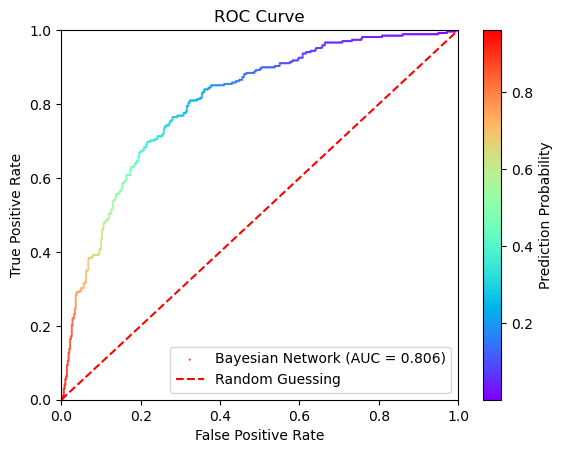

Training with arguments {'alpha': 0, 'threshold': 0.30515622376018836}


,Predicted Positive,Predicted Negative
Actual Positive,20.2,6.6
Actual Negative,13.1,36.9


Precision: 0.607	Accuracy: 0.743
Recall:    0.754	F1 Score: 0.672


In [18]:
"""Training the model using cross-validation and returns the confusion matrix parameters
"""
def train_full_cross_split(network, binned_dataset, alpha=0, threshold=0.5, fold=10):
    shuffled_training_dataset = binned_dataset.sample(frac=1)
    split_training_dataset = [shuffled_training_dataset.iloc[i * len(binned_dataset) // fold:(i+1) * len(binned_dataset) // fold, :] for i in range(0, fold)]
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(fold):
        train_data = pd.concat(split_training_dataset[:i] + split_training_dataset[i+1:])
        test_data = split_training_dataset[i]
        network.estimate_probabilities(train_data, alpha=alpha)
        for _, row in test_data.iterrows():
            evidence = {col: row[col] for col in row.index if col != "Outcome" and not pd.isna(row[col])}
            result = inference_variable_elimination(network, "Outcome", evidence)
            expected = row["Outcome"]
            prob = result[1]
            if prob >= threshold and expected == 1:
                tp += 1
            elif prob < threshold and expected == 0:
                tn += 1
            elif prob >= threshold and expected == 0:
                fp += 1
            else:
                fn += 1
    return tp/fold, tn/fold, fp/fold, fn/fold

"""calculates and displays the confusion matrix
"""
def test_parameters(network, binned_dataset, **kargs):
    print(f"Training with arguments {kargs}")

    tp, tn, fp, fn = train_full_cross_split(network, binned_dataset, **kargs)

    display(pd.DataFrame({
        "Predicted Positive": [tp, fp],
        "Predicted Negative": [fn, tn]
    }, index=["Actual Positive", "Actual Negative"]))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    f1_score = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0
    print(f"Precision: {precision:.3f}\tAccuracy: {accuracy:.3f}")
    print(f"Recall:    {recall:.3f}\tF1 Score: {f1_score:.3f}")

"""Calculates the ROC AUC score and returns the points for plotting the ROC curve  
"""
def roc_auc(network, binned_dataset, alpha=0, fold=10):
    actual = []
    predicted_probs = []

    shuffled_training_dataset = binned_dataset.sample(frac=1)
    split_training_dataset = [shuffled_training_dataset.iloc[i * len(binned_dataset) // fold:(i+1) * len(binned_dataset) // fold, :] for i in range(0, fold)]
    tp, fp = 0, 0
    for i in range(fold):
        train_data = pd.concat(split_training_dataset[:i] + split_training_dataset[i+1:])
        test_data = split_training_dataset[i]
        network.estimate_probabilities(train_data, alpha=alpha)
        for _, row in test_data.iterrows():
            evidence = {col: row[col] for col in row.index if col != "Outcome" and not pd.isna(row[col])}
            prob = inference_variable_elimination(network, "Outcome", evidence)
            actual.append(row["Outcome"])
            predicted_probs.append(prob[1])

    total_pos = sum(actual)
    total_neg = len(actual) - total_pos

    sorted_pairs = sorted(zip(predicted_probs, actual), reverse=True)
    points = []

    auc = 0
    prev_tp, prev_fp = 0, 0
    tp, fp = 0, 0
    for prob, actual in sorted_pairs:
        if actual == 1:
            tp += 1
        else:
            fp += 1

        if fp > prev_fp:
            auc += (tp + prev_tp) / (2 * total_pos * total_neg)
        prev_tp, prev_fp = tp, fp

        points.append((fp / total_neg, tp / total_pos, prob))

    return auc, points

### plotting the roc curve to asses the model performance
auc, points = roc_auc(network, binned_dataset, alpha=0)
for x, y, p in points:
    if 1 - x < y:
        print(f"Best threshold estimation: {p:.3f} | Specificity: {1 - x:.3f}\tSensitivity: {y:.3f}")
        break
x, y, c = zip(*points)
plt.scatter(x, y, s=0.2, c=c, cmap="rainbow", label=f"Bayesian Network (AUC = {auc:.3f})")
plt.colorbar(label="Prediction Probability")
plt.plot([0, 1], [0, 1], linestyle="--", color="red", label="Random Guessing")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("ROC Curve")
plt.legend()
plt.show()

test_parameters(network, binned_dataset, alpha=0, threshold=p)

### Testing for a bigger dataset found on internet https://pmc.ncbi.nlm.nih.gov/articles/PMC10057336/#:~:text=With%20the%20right%20model%2C%20doctors,%2C%20and%20age%20%5B8%5D


In [19]:
##testing for a bigger dataset found on internet
path = "data/diabetes2.csv"
raw_dataset = pd.read_csv(path)
raw_dataset.describe()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.502922e+06,3.224533,107.856867,71.220667,28.814000,137.852133,31.509646,0.398968,30.137733,0.333333
std,2.892534e+05,3.391020,31.981975,16.758716,14.555716,133.068252,9.759000,0.377944,12.089703,0.471420
min,1.000038e+06,0.000000,44.000000,24.000000,7.000000,14.000000,18.200512,0.078044,21.000000,0.000000
25%,1.252866e+06,0.000000,84.000000,58.000000,15.000000,39.000000,21.259887,0.137743,22.000000,0.000000
50%,1.505508e+06,2.000000,104.000000,72.000000,31.000000,83.000000,31.767940,0.200297,24.000000,0.000000
75%,1.755205e+06,6.000000,129.000000,85.000000,41.000000,195.000000,39.259692,0.616285,35.000000,1.000000
max,1.999997e+06,14.000000,192.000000,117.000000,93.000000,799.000000,56.034628,2.301594,77.000000,1.000000


In [20]:
raw_dataset = raw_dataset.rename(columns={
    "PlasmaGlucose": "Glucose",
    "DiastolicBloodPressure": "BloodPressure",
    "TricepsThickness": "SkinThickness",
    "SerumInsulin": "Insulin",
    "BMI": "BMI",
    "DiabetesPedigree": "DiabetesPedigreeFunction",
    "Age": "Age",
    "Pregnancies": "Pregnancies",
    "Diabetic": "Outcome"
})

In [21]:
raw_dataset = raw_dataset.drop(columns=["PatientID"])

In [22]:
raw_dataset.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,3.224533,107.856867,71.220667,28.814000,137.852133,31.509646,0.398968,30.137733,0.333333
std,3.391020,31.981975,16.758716,14.555716,133.068252,9.759000,0.377944,12.089703,0.471420
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200512,0.078044,21.000000,0.000000
25%,0.000000,84.000000,58.000000,15.000000,39.000000,21.259887,0.137743,22.000000,0.000000
50%,2.000000,104.000000,72.000000,31.000000,83.000000,31.767940,0.200297,24.000000,0.000000
75%,6.000000,129.000000,85.000000,41.000000,195.000000,39.259692,0.616285,35.000000,1.000000
max,14.000000,192.000000,117.000000,93.000000,799.000000,56.034628,2.301594,77.000000,1.000000


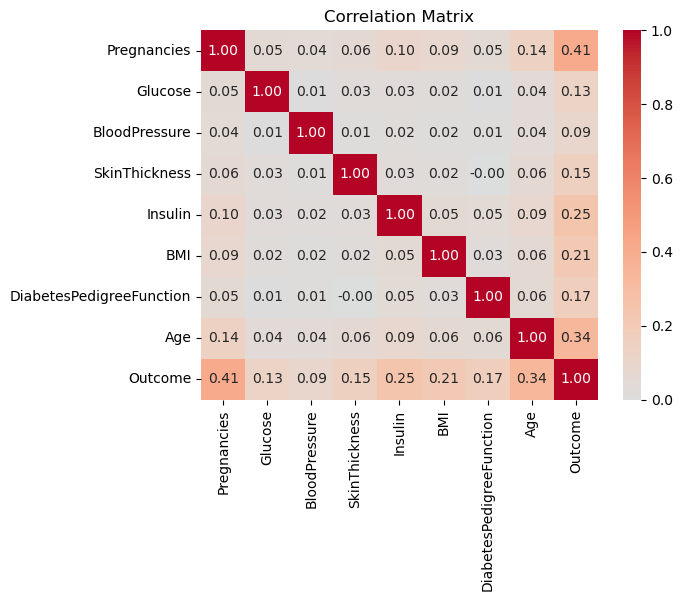

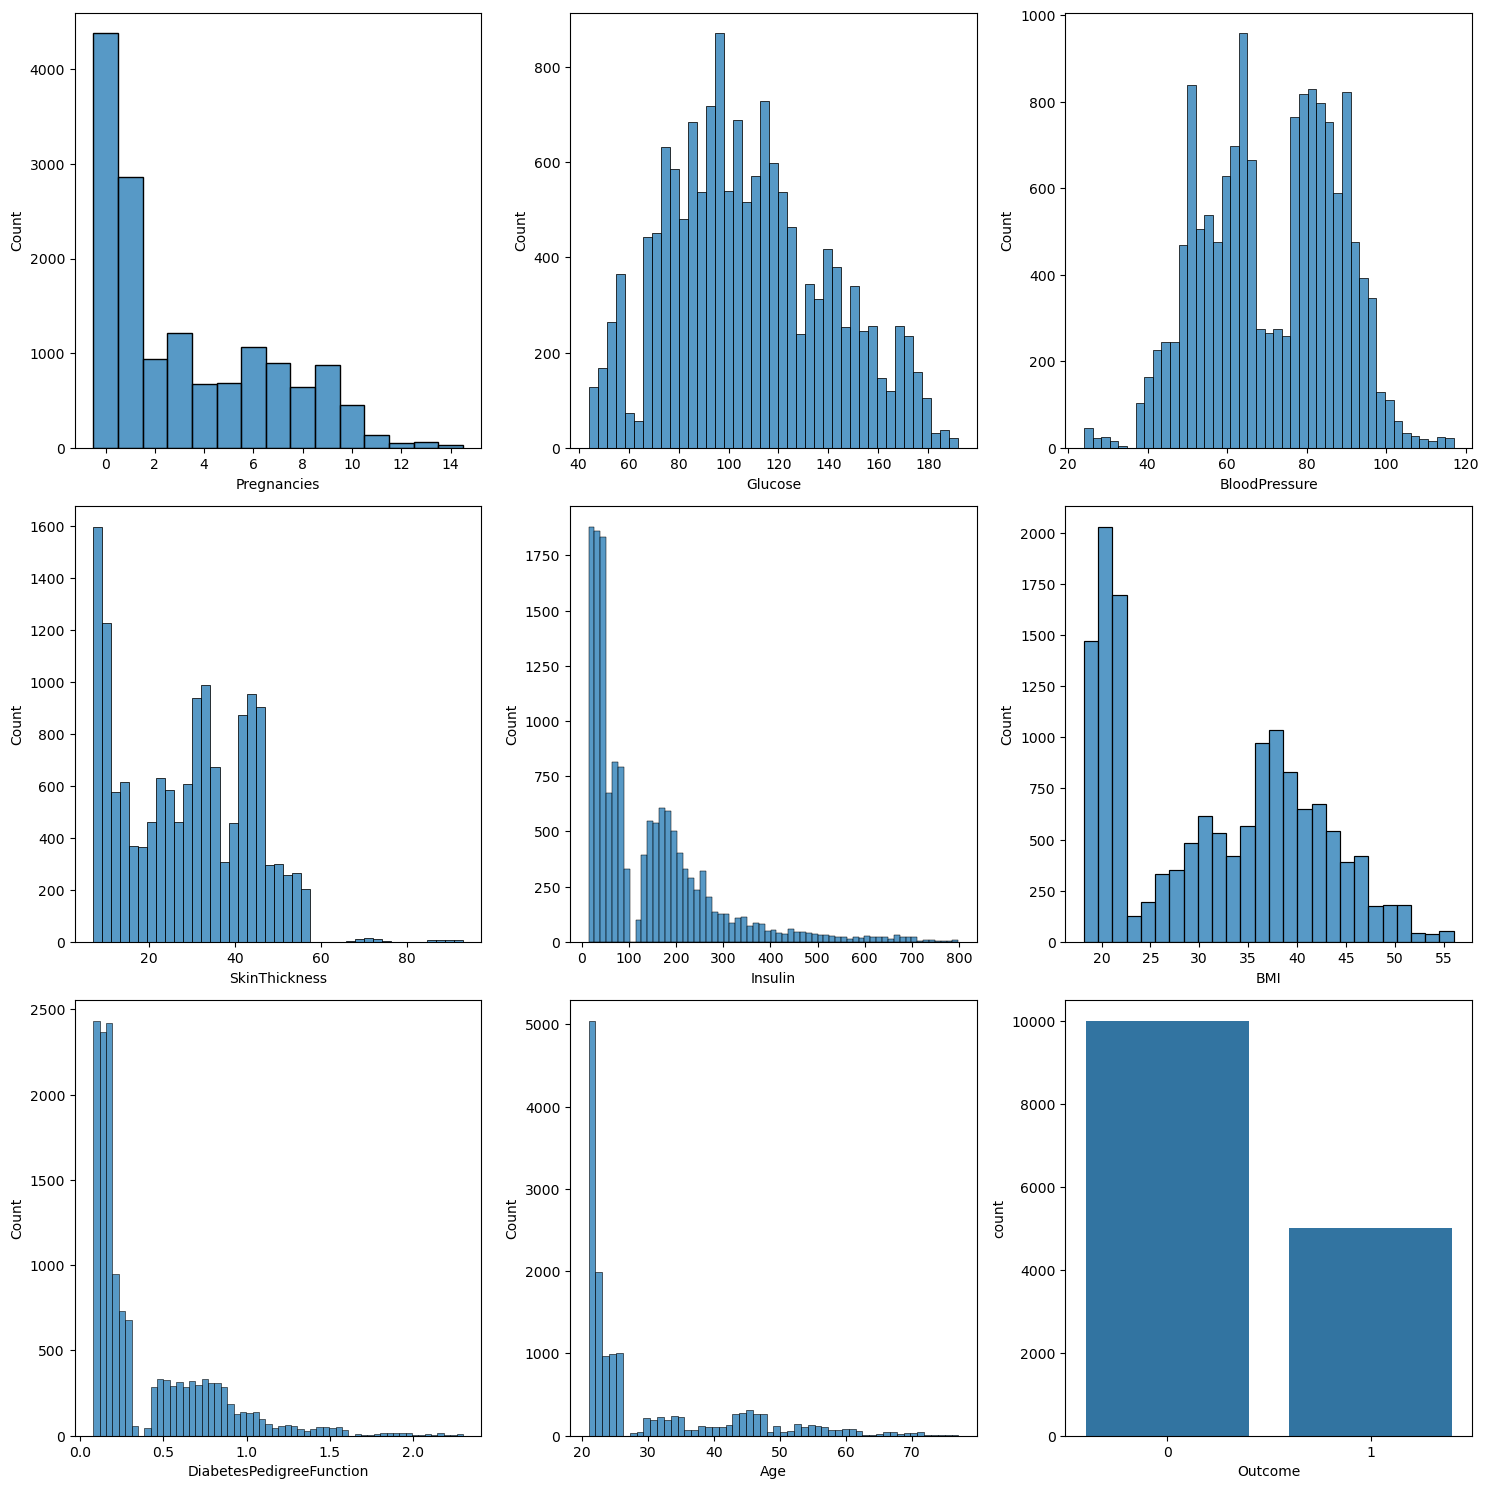

In [23]:
full_dataset = raw_dataset.copy()

non_null_columns = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
full_dataset[non_null_columns] = full_dataset[non_null_columns].replace(0, np.nan)

correlation_matrix = full_dataset.dropna().corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", center=0, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
sns.histplot(full_dataset["Pregnancies"].dropna(), ax=axes[0, 0], discrete=True)
sns.histplot(full_dataset["Glucose"].dropna(), ax=axes[0, 1])
sns.histplot(full_dataset["BloodPressure"].dropna(), ax=axes[0, 2])
sns.histplot(full_dataset["SkinThickness"].dropna(), ax=axes[1, 0])
sns.histplot(full_dataset["Insulin"].dropna(), ax=axes[1, 1])
sns.histplot(full_dataset["BMI"].dropna(), ax=axes[1, 2])
sns.histplot(full_dataset["DiabetesPedigreeFunction"].dropna(), ax=axes[2, 0])
sns.histplot(full_dataset["Age"].dropna(), ax=axes[2, 1])
sns.countplot(data=full_dataset, x="Outcome", ax=axes[2, 2])
plt.tight_layout()
plt.show()

In [24]:
binned_dataset2 = full_dataset.copy()
bin_column(binned_dataset2, "Glucose", 5)
bin_column(binned_dataset2, "BloodPressure", 2)
bin_column(binned_dataset2, "SkinThickness", 3)
bin_column(binned_dataset2, "Insulin", 4)
bin_column(binned_dataset2, "BMI", 3)
bin_column(binned_dataset2, "DiabetesPedigreeFunction", 2)
bin_column(binned_dataset2, "Age", 4)
bin_column(binned_dataset2, "Pregnancies", 3)

Best threshold estimation: 0.367 | Specificity: 0.903	Sensitivity: 0.903


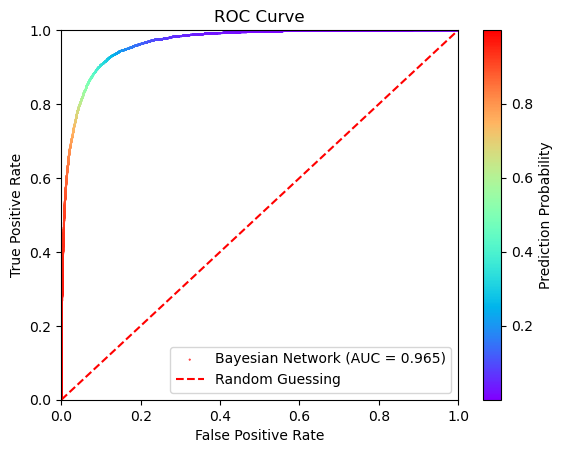

Training with arguments {'alpha': 0, 'threshold': 0.36707151329733373}


,Predicted Positive,Predicted Negative
Actual Positive,451.0,49.0
Actual Negative,96.8,903.2


Precision: 0.823	Accuracy: 0.903
Recall:    0.902	F1 Score: 0.861


In [25]:
### plotting the roc curve to asses the model performance
auc, points = roc_auc(network, binned_dataset2, alpha=0)
for x, y, p in points:
    if 1 - x < y:
        print(f"Best threshold estimation: {p:.3f} | Specificity: {1 - x:.3f}\tSensitivity: {y:.3f}")
        break
x, y, c = zip(*points)
plt.scatter(x, y, s=0.2, c=c, cmap="rainbow", label=f"Bayesian Network (AUC = {auc:.3f})")
plt.colorbar(label="Prediction Probability")
plt.plot([0, 1], [0, 1], linestyle="--", color="red", label="Random Guessing")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("ROC Curve")
plt.legend()
plt.show()

test_parameters(network, binned_dataset2, alpha=0, threshold=p)